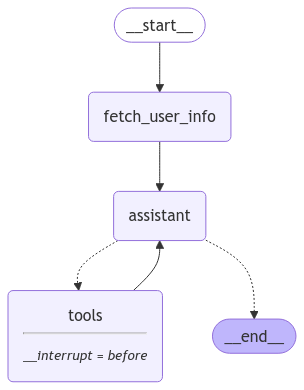

In [3]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display, HTML
from state import State
from utilities import create_tool_node_with_fallback

from flightstool import fetch_user_flight_information

import os


os.environ["TAVILY_API_KEY"] = "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"

from agentassistant import Assistant, part_1_assistant_runnable, part_1_tools


builder = StateGraph(State)

def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")

# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge("fetch_user_info", "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
part_2_graph = builder.compile(checkpointer=memory, interrupt_before=["tools"])

try:
    display(
        Image(part_2_graph.get_graph(xray=True).draw_mermaid_png())
    )
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [4]:
import shutil
import uuid
from dbpopulation import db, update_dates
from utilities import _print_event
from langchain_core.messages.tool import ToolMessage

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "8140 620813",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_2_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_2_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = part_2_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_2_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_2_graph.get_state(config)

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================

 To check the departure time for your flight, please provide me with the flight number and date.

Here's a list of functions that can help you manage your bookings:
1. `book_flight` - Book a new flight
2. `get_flight_details` - Get details about an existing flight booking
3. `cancel_flight` - Cancel an existing flight booking
4. `check_in` - Check-in for an upcoming flight
5. `get_boarding_pass` - Generate a boarding pass for your upcoming flight
6. `get_flight_status` - Get the current status of your flight (e.g., delayed, on time)
7. `reschedule_flight` - Reschedule an existing flight booking
8. `upgrade_flight` - Upgrade an existing flight booking to a higher class

If you have any other inquiries or need assistance with something else, feel free to ask!
================================ H